# Exploratory data analysis for Denver Crime data.

The data I am using for this analysis comes from the Denver Open Data Catolog. The catolog contains crime data from January 2013 until February 19, 2018. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline

In [2]:
# read in crime statistics from city of Denver, from Jan 2013 - Feb 19, 2018.
denver_df = pd.read_csv("crime.csv")

# look at data
denver_df.head()

# check size of dataframe
denver_df.shape

# look for invisible characters in column names
denver_df.columns

# look at data types and see which columns have missing values.
denver_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438604 entries, 0 to 438603
Data columns (total 19 columns):
INCIDENT_ID               438604 non-null int64
OFFENSE_ID                438604 non-null int64
OFFENSE_CODE              438604 non-null int64
OFFENSE_CODE_EXTENSION    438604 non-null int64
OFFENSE_TYPE_ID           438604 non-null object
OFFENSE_CATEGORY_ID       438604 non-null object
FIRST_OCCURRENCE_DATE     438604 non-null object
LAST_OCCURRENCE_DATE      147450 non-null object
REPORTED_DATE             438604 non-null object
INCIDENT_ADDRESS          393691 non-null object
GEO_X                     435210 non-null float64
GEO_Y                     435210 non-null float64
GEO_LON                   435210 non-null float64
GEO_LAT                   435210 non-null float64
DISTRICT_ID               438604 non-null int64
PRECINCT_ID               438604 non-null int64
NEIGHBORHOOD_ID           438604 non-null object
IS_CRIME                  438604 non-null int64
IS_TRAFFIC

In [3]:
#All the variables I am interested in have non-null values
#meta data states that crimes occuring at least 30 days from release date are most accurate. 
#I am going to remove all data from 2018 to be conservative.
# convert date column I am interested in to datetime
denver_df['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(denver_df['FIRST_OCCURRENCE_DATE'])

# remove 2018 data
denver_df = denver_df[denver_df['FIRST_OCCURRENCE_DATE'].dt.year < 2018]

### Crime reported over time

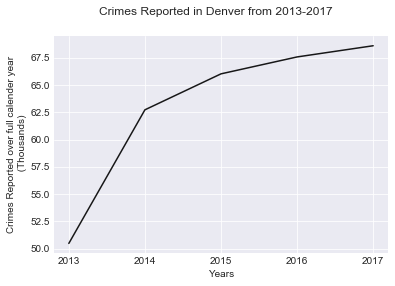

In [4]:
#add year and month column
denver_df['year'], denver_df['month'] = denver_df['FIRST_OCCURRENCE_DATE'].dt.year, denver_df['FIRST_OCCURRENCE_DATE'].dt.month

# group crime and traffic stats by year
year_crime_and_traffic = denver_df.groupby(['year'])[['IS_CRIME', 'IS_TRAFFIC']].sum().reset_index()

# group crime and traffic stats by month also
year_month_crime_and_traffic = denver_df.groupby(['year', 'month'])[['IS_CRIME', 'IS_TRAFFIC']].sum().reset_index()

#plot line graph of crime over the years.
sns.set_style("darkgrid")
plt.plot(year_crime_and_traffic['year'], year_crime_and_traffic['IS_CRIME']/1000,'-', color = 'black', alpha=0.9)
plt.suptitle('Crimes Reported in Denver from 2013-2017')
plt.ylabel('Crimes Reported over full calender year\n (Thousands)')
plt.xlabel('Years')
plt.xticks(year_crime_and_traffic['year'])
sns.despine();

Crime has been on the rise in Denver since 2013. Interestingly, there is a sharp rise from 2013 to 2014. In January of 2014, marijuana purchase became legal in Colorado. This could have something to do with the rise in crime, but I am going to dig deeper to be sure.

### Can the increase in crime be explained by an increase in population?

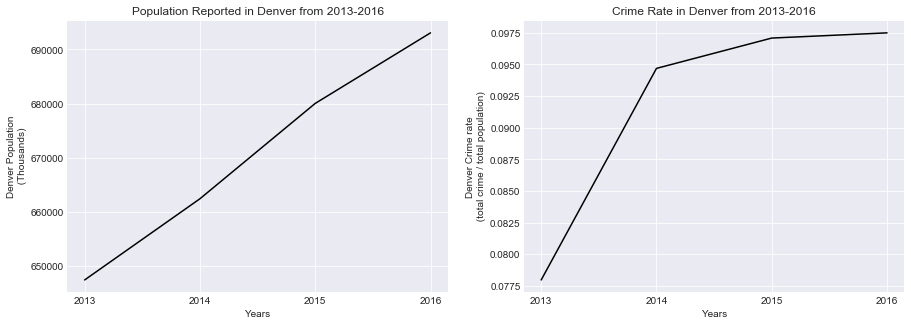

In [5]:
# Is there a large change in population from 2013 to 2014 (Pop data from Denver open Data Catalogue).
denver_pop = {'year': [2013, 2014, 2015, 2016], 'population': [647433,662425,680032,693060], 'crime': [50475,62721,66018,67568]}
denver_pop_df = pd.DataFrame(data=denver_pop)

# add_crime rate (reported crimes / total population)
denver_pop_df['crime rate'] = denver_pop_df['crime']/denver_pop_df['population']

plt.figure(figsize=(15, 5))

#plot line graph of crime over years.
plt.subplot(1, 2, 1)
sns.set_style("darkgrid")
plt.plot(denver_pop_df['year'], denver_pop_df['population'],'-', color = 'black')
plt.title('Population Reported in Denver from 2013-2016')
plt.ylabel('Denver Population\n (Thousands)')
plt.xlabel('Years')
plt.xticks(denver_pop_df['year'])
sns.despine();

#plot line graph of crime rate.
plt.subplot(1, 2, 2)
sns.set_style("darkgrid")
plt.plot(denver_pop_df['year'], denver_pop_df['crime rate'],'-', color = 'black')
plt.title('Crime Rate in Denver from 2013-2016')
plt.ylabel('Denver Crime rate\n (total crime / total population)')
plt.xlabel('Years')
plt.xticks(denver_pop_df['year'])
sns.despine();

#plotting a crime and population scatter while 
#fitting a line would be another informative plot

Population growth (left): Since 2013, population growth in Denver has been fairly linear. 
Crime rate (right): the number of crimes per person also jumped up from 2013-2014 suggesting that increased population did not play a role in the rise in crime during that period.

###   Did a category of crimes disproportionally increase relative to other crimes during this period? 

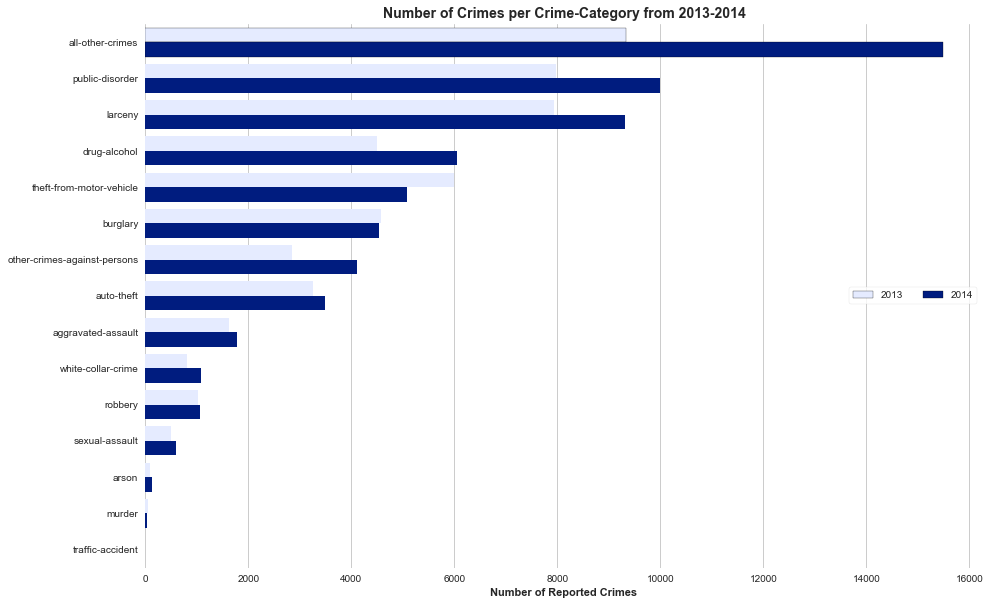

In [6]:
# Are certain crimes being committed more often?
offense_by_year = denver_df.groupby(['year', 'OFFENSE_CATEGORY_ID'])[['IS_CRIME']].sum().sort_values('IS_CRIME', ascending=False).reset_index()

# look to see if a crime category changed from 2013-2014
offense_by_year_2013_2014 = offense_by_year[offense_by_year['year'] < 2015]

# initialize figure
sns.set(style="whitegrid")
plt.subplots(figsize=(15, 10))

# barplot showing number of crimes per cime category per yer
sns.set_color_codes("dark")
sns.barplot(x='IS_CRIME', y='OFFENSE_CATEGORY_ID', data=offense_by_year_2013_2014, hue='year', color="b", edgecolor='black', saturation=1)

# Add a legend and informative axis label
plt.legend(ncol=2, loc="right", frameon=True)
sns.despine(left=True, bottom=True)
plt.title('Number of Crimes per Crime-Category from 2013-2014', fontsize=14, fontweight='bold')
plt.xlabel('Number of Reported Crimes',fontweight='bold')
plt.ylabel('')
plt.show();

# you can visually see what categories are higher in 2014, but
# see if plotting the proportions (2014/2013) make this visualization better
# a pie chart might even work here..test it

Drug and alcohol arrest are up but so are most of the crime categories from 2013-2014. The largest increase appears to be the all-other-crimes category.

### What crimes make up the "all-other-crimes" category?

In [7]:
# look at offense type ids and see how many occured per year
offense_type_by_year = denver_df.groupby(['year', 'OFFENSE_CATEGORY_ID','OFFENSE_TYPE_ID'])[['IS_CRIME']].sum().sort_values('IS_CRIME', ascending=False).reset_index()

# look at years there was the big jump in crime
offense_by_year_2013 = offense_type_by_year[offense_type_by_year['year'] == 2013]
offense_by_year_2014 = offense_type_by_year[offense_type_by_year['year'] == 2014]

print(offense_by_year_2013[offense_by_year_2013['OFFENSE_CATEGORY_ID'] == 'all-other-crimes'].head(20))
print('\n')
print(offense_by_year_2014[offense_by_year_2014['OFFENSE_CATEGORY_ID'] == 'all-other-crimes'].head(20))

     year OFFENSE_CATEGORY_ID                 OFFENSE_TYPE_ID  IS_CRIME
19   2013    all-other-crimes                      traf-other      3081
71   2013    all-other-crimes            criminal-trespassing      1412
84   2013    all-other-crimes       public-order-crimes-other      1151
152  2013    all-other-crimes        police-false-information       495
168  2013    all-other-crimes  violation-of-restraining-order       417
179  2013    all-other-crimes          traf-habitual-offender       363
205  2013    all-other-crimes        violation-of-court-order       260
216  2013    all-other-crimes             police-interference       225
221  2013    all-other-crimes      vehicular-eluding-no-chase       214
235  2013    all-other-crimes        sex-off-fail-to-register       183
252  2013    all-other-crimes               failure-to-appear       156
259  2013    all-other-crimes   weapon-by-prev-offender-powpo       146
294  2013    all-other-crimes         police-resisting-arrest   

The crimes are varied. 
#### If your interested in seeing if the list are different you could rank the crimes for each year and do a spearmans rank correlation.

### Does a specific neighborhood account for the jump in crime.

In [8]:
# Does a specific neighborhood account for the jump in crime.
neighborhood_citations = denver_df.groupby(['year','NEIGHBORHOOD_ID'])[['IS_CRIME']].sum().reset_index()

# dfs for 2013-2014 comparison
neighborhood_citations_2013 = neighborhood_citations[neighborhood_citations['year'] == 2013]
neighborhood_citations_2014 = neighborhood_citations[neighborhood_citations['year'] == 2014]

# rename columns for 2013 and 2014 dfs
neighborhood_citations_2013 .columns = ['year_2013', 'NEIGHBORHOOD_ID_2013', 'IS_CRIME_2013']
neighborhood_citations_2014.columns = ['year_2014', 'NEIGHBORHOOD_ID_2014', 'IS_CRIME_2014']

# merge 2013 and 2014 data
neighborhood_citations_2013_2014 = neighborhood_citations_2013 .merge(neighborhood_citations_2014, left_on='NEIGHBORHOOD_ID_2013', right_on='NEIGHBORHOOD_ID_2014', how='inner')

# create crime pct per neighborhood
neighborhood_citations_2013_2014['IS_CRIME_2013_PCT']  =  neighborhood_citations_2013_2014['IS_CRIME_2013']*100 / 50475
neighborhood_citations_2013_2014['IS_CRIME_2014_PCT']  =  neighborhood_citations_2013_2014['IS_CRIME_2014']*100 / 62721

# determine percent change in neighborhood crime from 2013-2014
neighborhood_citations_2013_2014['IS_CRIME_CHANGE_PCT']  = neighborhood_citations_2013_2014['IS_CRIME_2014_PCT'] - neighborhood_citations_2013_2014['IS_CRIME_2013_PCT']
neighborhood_citations_2013_2014.sort_values(['IS_CRIME_2014'], ascending=False)

# check to see what the percent change descriptive stats are. Max percent change is 0.7 and min is -.46
neighborhood_citations_2013_2014['IS_CRIME_CHANGE_PCT'].describe()

#How many neighborhood had an increase in crime percent-33, decrease-45
neighborhood_citations_2013_2014[neighborhood_citations_2013_2014['IS_CRIME_CHANGE_PCT'] >0].count()
neighborhood_citations_2013_2014[neighborhood_citations_2013_2014['IS_CRIME_CHANGE_PCT'] <0].count()

# change in amount of crime from 2013-2014 per neighborhood, 72 increased, 6 decrease.
neighborhood_citations_2013_2014['IS_CRIME_CHANGE']  =  neighborhood_citations_2013_2014['IS_CRIME_2014'] - neighborhood_citations_2013_2014['IS_CRIME_2013']
increasedCrime = neighborhood_citations_2013_2014[neighborhood_citations_2013_2014['IS_CRIME_CHANGE'] >0].count()
decreasedCrime = neighborhood_citations_2013_2014[neighborhood_citations_2013_2014['IS_CRIME_CHANGE'] <0].count()


There is not a specific neighborhood that experienced a disproportionate increase in crime. Overall 72 neighborhoods saw an increase in crime and 6 a decrease. Also, the percentage of total crimes occurring in specific neighborhoods  in 2014 are distributed similarly to what was seen in 2013. The max change increase a neighborhood saw in total crime relative to the rest of the city was 0.7% while the min change was 0.46%. Taken together, this suggest an overall increase in crime and not a neighborhood specific phenomenon.

# Ok. So there has been a citywide incease in crime since 2014. To test if video surveillance effectively lowers crime in the city we need to first identify test neighborhoods and controls, as well as the length of time to run the study.

Randomly choose which neighborhoods get the surveillance video after splitting neighborhoods into quartiles?

In [184]:
# group crime data by neighborhood and get mean crime
denver_crime_mean = denver_df_year.groupby(['NEIGHBORHOOD_ID'])[['IS_CRIME']].mean().sort_values(by='IS_CRIME', ascending=False)

# bin neighborhods with crime numbers in the top 75th, 50-75th, and 25-50th and less than 25th percentile for comparisons.  
denver_75th = denver_crime_mean[denver_crime_mean['IS_CRIME'] >= denver_crime_mean['IS_CRIME'].quantile(q=0.75)].reset_index()
denver_50to75th = denver_crime_mean[(denver_crime_mean['IS_CRIME'].quantile(q=0.50) <= denver_crime_mean['IS_CRIME'])  & (denver_crime_mean['IS_CRIME'] < denver_crime_mean['IS_CRIME'].quantile(q=0.75))].reset_index()
denver_25to50th = denver_crime_mean[(denver_crime_mean['IS_CRIME'].quantile(q=0.25) < denver_crime_mean['IS_CRIME'])  & (denver_crime_mean['IS_CRIME'] < denver_crime_mean['IS_CRIME'].quantile(q=0.50))].reset_index()
denver_25th = denver_crime_mean[denver_crime_mean['IS_CRIME'] <= denver_crime_mean['IS_CRIME'].quantile(q=0.25)].reset_index()

# randomly select 3 samples from each percentile bins, use random state for reproducibiity.
test_75th = denver_75th.sample(n=3, random_state=2).reset_index()
test_50to75th = denver_50to75th.sample(n=3, random_state=2).reset_index()
test_25to50th = denver_25to50th.sample(n=3, random_state=2).reset_index()
test_25th = denver_25th.sample(n=3, random_state=2).reset_index()

print('Test neighborhoods for 75th percentile group\n\n',test_75th)
print('\n')
print('Test neighborhoods for 50-75th percentile group\n\n',test_50to75th)
print('\n')
print('Test neighborhoods for 25-50th percentile group\n\n',test_25to50th)
print('\n')
print('Test neighborhoods for 25th percentile group\n\n',test_25th)

Test neighborhoods for 75th percentile group

    index NEIGHBORHOOD_ID  IS_CRIME
0     12           baker    1310.4
1      4    capitol-hill    2225.4
2     18   cheesman-park     964.2


Test neighborhoods for 50-75th percentile group

    index NEIGHBORHOOD_ID  IS_CRIME
0      9             dia     756.6
1      4       ruby-hill     874.8
2     14            cole     647.6


Test neighborhoods for 25-50th percentile group

    index NEIGHBORHOOD_ID  IS_CRIME
0      9     lowry-field     491.0
1      4        overland     515.0
2     14        whittier     476.0


Test neighborhoods for 25th percentile group

    index  NEIGHBORHOOD_ID  IS_CRIME
0     12          kennedy     278.0
1      4  university-park     380.8
2     18     indian-creek      83.2


We have 12 randomly chosen neighborhoods. Three per quartile.

## Now we need to see how the test neighborhoods distribution compares to the distribution of non-test neighborhoods from the same quartile.

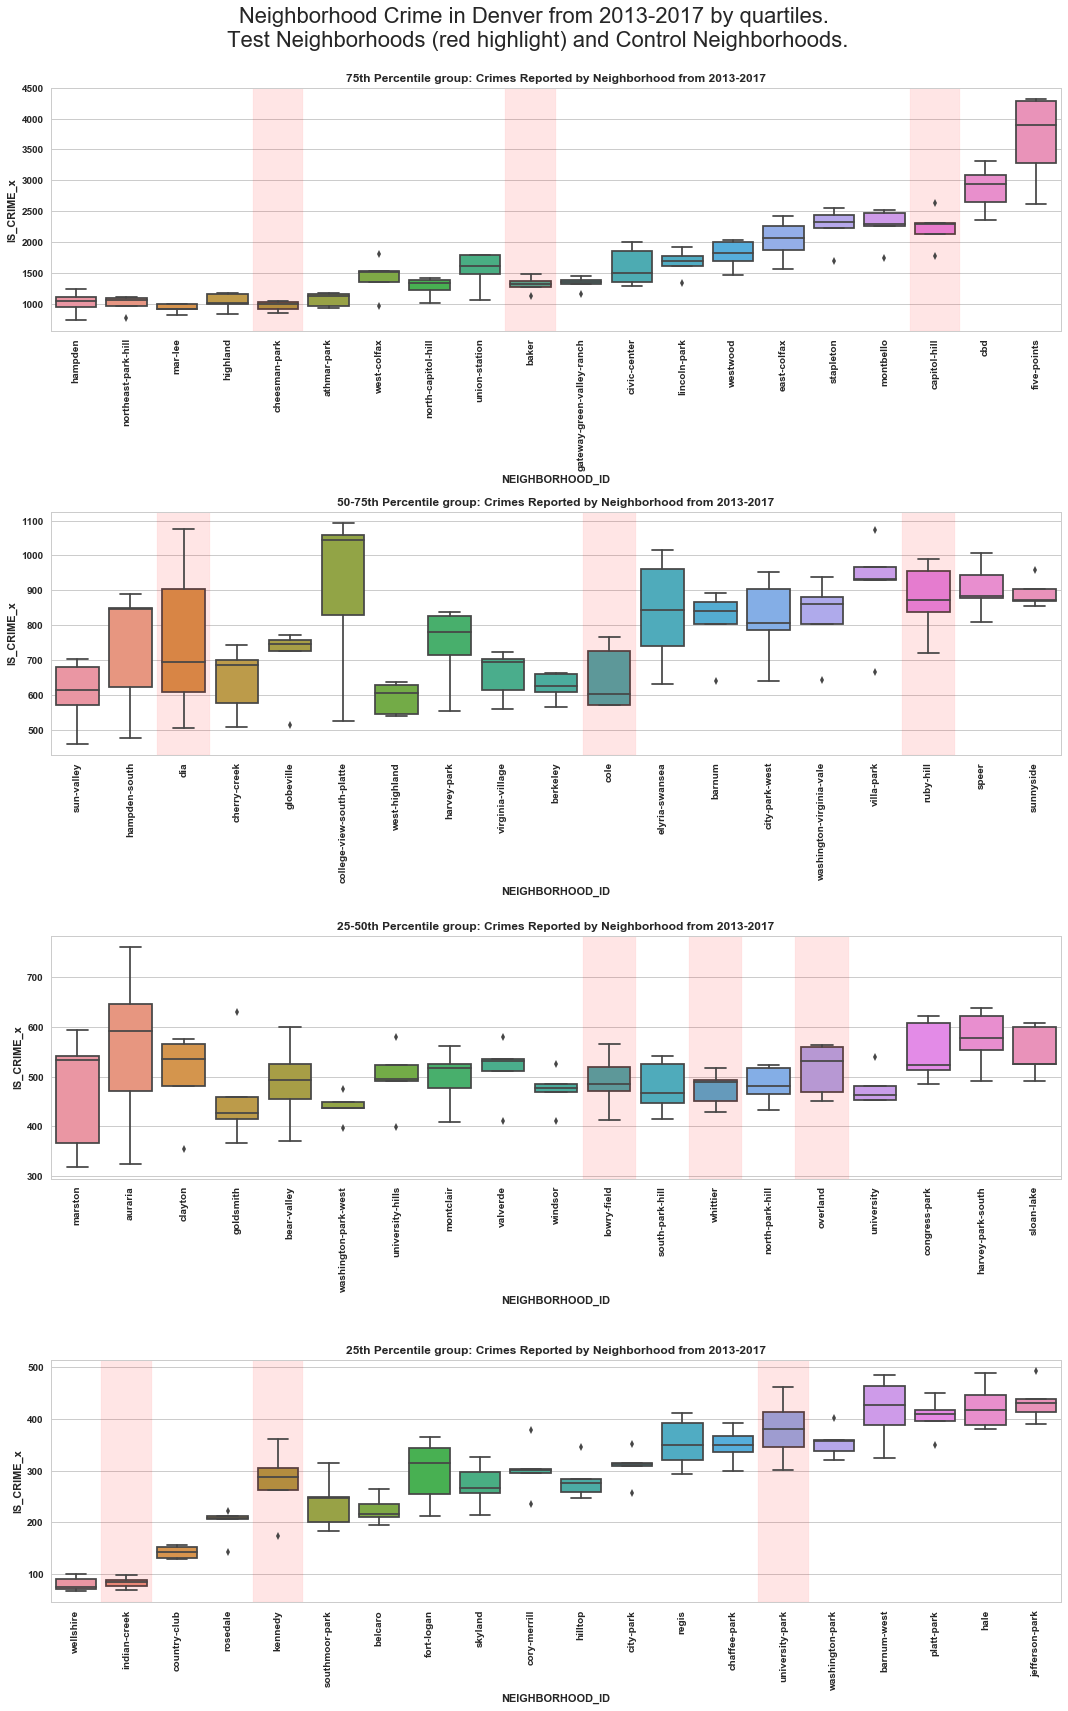

In [174]:
# groupby year and neighborhood and get sum of crimes
denver_crime_sum = denver_df_year.groupby(['year','NEIGHBORHOOD_ID'])[['IS_CRIME']].sum().reset_index()

# bin neighborhoods into their respective quartiles using join.
crimeSum_75th = pd.merge(denver_crime_sum, denver_75th, how='right', on='NEIGHBORHOOD_ID').sort_values(by='IS_CRIME_x')
crimeSum_50to75th = pd.merge(denver_crime_sum, denver_50to75th, how='right', on='NEIGHBORHOOD_ID').sort_values(by='IS_CRIME_x')
crimeSum_25to50th = pd.merge(denver_crime_sum, denver_25to50th, how='right', on='NEIGHBORHOOD_ID').sort_values(by='IS_CRIME_x')
crimeSum_25th = pd.merge(denver_crime_sum, denver_25th, how='right', on='NEIGHBORHOOD_ID').sort_values(by='IS_CRIME_x')

#plot global parameters
plt.rcParams['figure.figsize']=(15,25)
plt.rcParams["font.weight"] = "bold"

# plot 75th percentile test neighborhoods and non-test neighborhoods
plt.subplot(4, 1, 1)
ax =sns.boxplot(x="NEIGHBORHOOD_ID", y="IS_CRIME_x", data=crimeSum_75th)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('75th Percentile group: Crimes Reported by Neighborhood from 2013-2017', fontweight='bold')
plt.axvspan(3.5,4.5, color='red', alpha=0.1)
plt.axvspan(8.5,9.5, color='red', alpha=0.1)
plt.axvspan(16.5,17.5, color='red', alpha=0.1)

# plot 50-75th percentile test neighborhoods and non-test neighborhoods
plt.subplot(4, 1, 2)
ax =sns.boxplot(x="NEIGHBORHOOD_ID", y="IS_CRIME_x", data=crimeSum_50to75th)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('50-75th Percentile group: Crimes Reported by Neighborhood from 2013-2017', fontweight='bold')
plt.axvspan(1.5,2.5, color='red', alpha=0.1)
plt.axvspan(9.5,10.5, color='red', alpha=0.1)
plt.axvspan(15.5,16.5, color='red', alpha=0.1)

# plot 25-50th percentile test neighborhoods and non-test neighborhoods
plt.subplot(4, 1, 3)
ax =sns.boxplot(x="NEIGHBORHOOD_ID", y="IS_CRIME_x", data=crimeSum_25to50th)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('25-50th Percentile group: Crimes Reported by Neighborhood from 2013-2017', fontweight='bold')
plt.axvspan(9.5,10.5, color='red', alpha=0.1)
plt.axvspan(11.5,12.5, color='red', alpha=0.1)
plt.axvspan(13.5,14.5, color='red', alpha=0.1)

# plot 25th percentile test neighborhoods and non-test neighborhoods
plt.subplot(4, 1, 4)
ax =sns.boxplot(x="NEIGHBORHOOD_ID", y="IS_CRIME_x", data=crimeSum_25th)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('25th Percentile group: Crimes Reported by Neighborhood from 2013-2017', fontweight='bold' )
plt.axvspan(0.5,1.5, color='red', alpha=0.1)
plt.axvspan(3.5,4.5, color='red', alpha=0.1)
plt.axvspan(13.5,14.5, color='red', alpha=0.1)
plt.suptitle("Neighborhood Crime in Denver from 2013-2017 by quartiles.\n Test Neighborhoods (red highlight) and Control Neighborhoods.", size=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Boxplots of reported crimes from 2013-2017 grouped by neighborhood and quartiles. Neighborhoods that are highlighted are the randomly chosen test neighborhoods. 

## Check to see if the randomly chosen neighborhoods follow a normal distribution with a Shapiro-Wilk test.

In [183]:
# concatenate test df
test_only_df = pd.concat([test_75th, test_50to75th, test_25to50th, test_25th])

# test for normality
scipy.stats.shapiro(test_only_df['IS_CRIME'])

(0.8542250394821167, 0.04141426458954811)

The null hypothesis that the data is normally distributed can be rejected since the p-value is less than 0.05. Since the data does not follow a normal distribution a Wilcoxon sign rank test will be used. 

## How long do we need to run the study?

/Users/patrickgonzales/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


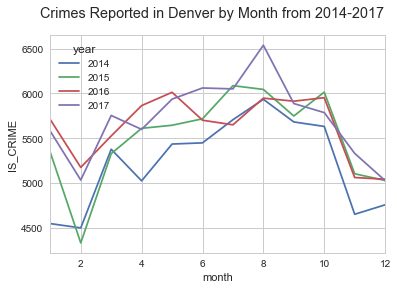

In [10]:
denver_df_monthly = denver_df.groupby(['year', 'month'])[['IS_CRIME']].sum().reset_index()
denver_df_2014_2017 = denver_df_monthly[denver_df_monthly ['year'] >= 2014].reset_index()
sns.tsplot(data=denver_df_2014_2017,time='month', unit='year',value='IS_CRIME', condition='year')
plt.suptitle('Crimes Reported in Denver by Month from 2014-2017');

There is definitely a seasonal pattern to crime here. The winter months have the lowest levels of crime and the summers tend to have higher numbers of reported crime. There are also certain months where crime consistently takes a dip, like February and November. Because of the seasonal patterns and the months where there is a dramatic shift in the amoun of reported crime I think we should look at data over the course of an entire year.